## Mount Drive for Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd gdrive/My\ Drive/1000ml/Project\ 6\ -\ Intrusion\ Detection/1000ml_Project6

/content/gdrive/My Drive/1000ml/Project 6 - Intrusion Detection/1000ml_Project6


# Imports

In [3]:
pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 9.4MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [4]:
pip install -U xgboost

     |████████████████████████████████| 109.8MB 93kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import chi2, SelectKBest, f_classif

from sklearn.metrics import precision_score, f1_score, recall_score

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

rand = 3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Set up

In [0]:
intrusion_df = pd.read_csv('data/variable_reduced_data.csv')

In [0]:
reduced_num_cols = ['wrong_fragment',
                    'hot',
                    'num_failed_logins',
                    'num_compromised',
                    'num_root',
                    'count',
                    'num_file_creations',
                    'num_shells', 
                    'num_access_files',
                    'srv_count',
                    'serror_rate',
                    'srv_serror_rate',
                    'dst_host_count',
                    'dst_host_srv_count',
                    'dst_host_same_srv_rate',
                    'dst_host_diff_srv_rate',
                    'dst_host_same_src_port_rate',
                    'dst_host_srv_diff_host_rate',
                    'dst_host_serror_rate',
                    'dst_host_srv_serror_rate',
                    'dst_host_rerror_rate',
                    'dst_host_srv_rerror_rate']

reduced_cat_cols = ['protocol_type = tcp',
                    'protocol_type = icmp',
                    'service = domain_u',
                    'service = http',
                    'service = smtp',
                    'service = ftp_data',
                    'service = ftp',
                    'service = other',
                    'service = ecr_i',
                    'service = telnet',
                    'service = tim_i',
                    'service = uucp',
                    'service = courier',
                    'service = private',
                    'flag = SF',
                    'flag = REJ',
                    'flag = SH',
                    'logged_in',
                    'is_host_login',
                    'is_guest_login',
                    'root_shell']

target=['target']

In [0]:
def print_scores(model, train_x, validation_x, train_y, validation_y):
    '''
    This function takes in a Classifier model that has previously been fit to a set of train data.
    It then calculates the predicted classifications and outputs the recall, precision and f1 scores
    for train and validation data sets
    '''
    y_train_pred = model.predict(train_x)
    y_val_pred = model.predict(validation_x)
    
    train_prec = precision_score(train_y, y_train_pred)
    val_prec = precision_score(validation_y, y_val_pred)
    
    train_f1 = f1_score(train_y, y_train_pred)
    val_f1 = f1_score(validation_y, y_val_pred)
    
    train_recall = recall_score(train_y, y_train_pred)
    val_recall = recall_score(validation_y, y_val_pred)
    
    print(f'''    Precision:
    Train = {train_prec.round(3)}
    Validation = {val_prec.round(3)}
    
    F1:
    Train = {train_f1.round(3)}
    Validation = {val_f1.round(3)}
    
    Recall:
    Train = {train_recall.round(3)}
    Validation = {val_recall.round(3)}    
    ''')

# Reset Models

In [0]:
# set, train test split and scale
# Set data
x = intrusion_df[reduced_num_cols+reduced_cat_cols]
y = intrusion_df['target']

# train val test split
x_rest, x_test, y_rest, y_test = TTS(x,y,test_size=0.20,random_state=3)
x_train, x_val, y_train, y_val = TTS(x_rest,y_rest,test_size=0.25,random_state=3)

transformed_cols = reduced_num_cols+reduced_cat_cols

# scale the numeric data
ct = ColumnTransformer(
            [("Num_Cols", StandardScaler(), reduced_num_cols),
             ("Cat_Cols", 'passthrough', reduced_cat_cols)
             ])

# Define scaled data as dataframes
x_train_scale = pd.DataFrame(ct.fit_transform(x_train), columns=transformed_cols)
x_val_scale = pd.DataFrame(ct.transform(x_val), columns=transformed_cols)
x_test_scale = pd.DataFrame(ct.transform(x_test), columns=transformed_cols)

## RandomForest Model: Default Class Balancing

In [0]:
# Create and fit model, print scores
rf_model = RandomForestClassifier(class_weight='balanced',
                                  random_state=rand,
                                  n_estimators=200,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  max_features=None,
                                  max_depth=20,
                                  criterion='gini'
                                 )
rf_model.fit(x_train_scale,y_train)

print_scores(rf_model, x_train_scale, x_val_scale, y_train, y_val)

    Precision:
    Train = 0.993
    Validation = 0.87
    
    F1:
    Train = 0.996
    Validation = 0.714
    
    Recall:
    Train = 1.0
    Validation = 0.606    
    


## RandomForest Model: SMOTETomek Class Balancing

Doesn't really work. Good try though buddy

In [0]:
combine = SMOTETomek(sampling_strategy='all', # resamples all the data 
                     random_state=rand, 
                     n_jobs=-1,
                     smote=SMOTE(),  # default parameters used
                     tomek=TomekLinks()  # default params used
                    )
                   
# fit and resample
x_train_rs, y_train_rs = combine.fit_resample(x_train,y_train)

In [0]:
# scale the numeric data
ct_bal = ColumnTransformer(
            [("Num_Cols", StandardScaler(), reduced_num_cols),
             ("Cat_Cols", 'passthrough', reduced_cat_cols)
             ])

# Scale the data with the column transformer
x_train_rs_scale = pd.DataFrame(ct_bal.fit_transform(x_train_rs), columns=transformed_cols)
x_val_rs_scale = pd.DataFrame(ct_bal.transform(x_val), columns=transformed_cols)

In [0]:
# Pick model based on the grid search from the RF section below.
rf_model_combine = RandomForestClassifier(class_weight='balanced',
                                          random_state=rand,
                                          n_estimators=150,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          max_features=None,
                                          max_depth=22,
                                          criterion='gini',
                                          n_jobs=-1
                                         )

In [0]:
# fit model
rf_model_combine.fit(x_train_rs_scale, y_train_rs)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=22, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [0]:
# Print the scores
print_scores(rf_model_combine, x_train_rs_scale, x_val_rs_scale, y_train_rs, y_val)

    Precision:
    Train = 1.0
    Validation = 0.54
    
    F1:
    Train = 1.0
    Validation = 0.651
    
    Recall:
    Train = 1.0
    Validation = 0.818    
    


### Now with a Pipeline

In [0]:
# (re)Define Pipeline Steps

# Combination method for over/under sampling
combine = SMOTETomek(sampling_strategy='all', # resamples all the data 
                     random_state=rand, 
                     n_jobs=-1, 
                     smote=SMOTE(),  # default parameters used
                     tomek=TomekLinks()  # default params used
                    )

# The column transformer - leaves discrete columns alone and standard scales the cts columns
ct_pipe = ColumnTransformer(
            [("Num_Cols", StandardScaler(), reduced_num_cols),
             ("Cat_Cols", 'passthrough', reduced_cat_cols)
             ])

# Random Forest model 
rf_model_combine = RandomForestClassifier(class_weight='balanced',
                                          random_state=rand,
                                          n_estimators=150,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          max_features=None,
                                          max_depth=22,
                                          criterion='gini',
                                          n_jobs=-1
                                         )

combine_pipe = Pipeline(steps=[('combo_sampler',combine),
                              ('scaler',ct_pipe),
                              ('model',rf_model_combine)])

combine_pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('combo_sampler',
                 SMOTETomek(n_jobs=-1, random_state=3, sampling_strategy='all',
                            smote=SMOTE(k_neighbors=5, n_jobs=None,
                                        random_state=None,
                                        sampling_strategy='auto'),
                            tomek=TomekLinks(n_jobs=None,
                                             sampling_strategy='auto'))),
                ('scaler',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   tra...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=22,
                                        max_features=None, max_leaf_nodes=Non

In [0]:
print_scores(combine_pipe, x_train, x_val, y_train, y_val)

    Precision:
    Train = 1.0
    Validation = 0.551
    
    F1:
    Train = 1.0
    Validation = 0.659
    
    Recall:
    Train = 1.0
    Validation = 0.818    
    


# Boosting

Plan: 
Explore XGBoost using normal

In [0]:
from xgboost import XGBClassifier as XGBc

In [0]:
xgb_model = XGBc(max_depth = 2,
                 random_state=rand,
                 learning_rate=0.05,
                 tree_method = 'gpu_hist',
                 booster = 'gbtree',
                 colsample_bytree=0.8,
                 colsample_bynode=0.8,
                 colsample_bylevel=0.8,
                 reg_alpha=1,
                 reg_lambda=1
                 )

In [12]:
xgb_model.fit(x_train_scale, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=3, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [13]:
print_scores(xgb_model, x_train_scale, x_test_scale, y_train, y_test)

    Precision:
    Train = 0.989
    Validation = 0.952
    
    F1:
    Train = 0.807
    Validation = 0.8
    
    Recall:
    Train = 0.681
    Validation = 0.69    
    


In [14]:
print_scores(xgb_model, x_train_scale, x_val_scale, y_train, y_val)

    Precision:
    Train = 0.989
    Validation = 1.0
    
    F1:
    Train = 0.807
    Validation = 0.755
    
    Recall:
    Train = 0.681
    Validation = 0.606    
    


### Pipeline

In [0]:
from sklearn.pipeline import Pipeline

In [0]:
ct_pipe = ColumnTransformer(
            [("Num_Cols", StandardScaler(), reduced_num_cols),
             ("Cat_Cols", 'passthrough', reduced_cat_cols)
             ])

xgb_pipe = XGBc(max_depth = 2,
                 random_state=rand,
                 learning_rate=0.05,
                 tree_method = 'gpu_hist',
                 booster = 'gbtree',
                 colsample_bytree=0.8,
                 colsample_bynode=0.8,
                 colsample_bylevel=0.8,
                 reg_alpha=1,
                 reg_lambda=1
                 )
pipe_xgb = Pipeline(steps=[('scaler',ct_pipe),
                           ('xgb',xgb_pipe)])

In [18]:
pipe_xgb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('Num_Cols',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['wrong_fragment', 'hot',
                                                   'num_failed_logins',
                                                   'num_compromised',
                                                   'num_root', 'count',
                                                   'num_file_creations',
                                                   'num_shells',
                                       

In [19]:
print_scores(pipe_xgb,x_train,x_val,y_train,y_val)

    Precision:
    Train = 0.989
    Validation = 1.0
    
    F1:
    Train = 0.807
    Validation = 0.755
    
    Recall:
    Train = 0.681
    Validation = 0.606    
    


In [29]:
pd.DataFrame(pipe_xgb.predict(x),columns=['Result'])

,Result
0,0
1,0
2,0
3,0
4,0
...,...
48108,0
48109,0
48110,0
48111,0


### Pickle the Model

In [0]:
import pickle

In [0]:
filename = 'finalized_model.sav'
pickle.dump(pipe_xgb, open(filename, 'wb'))

In [0]:
import joblib

In [26]:
filename2 = 'finalized_model2.sav'
joblib.dump(pipe_xgb, filename2)

['finalized_model2.sav']

## Try a grid search

The above looks sorta promising. See how much better we can do.

In [0]:
params_xgb = {'max_depth':[3,4,5,6],
              'learning_rate':np.logspace(-4,0,8),
             # 'max_depth':[18,19,20],
              'colsample_bytree':[0.8,1.0],
              'colsample_bylevel':[0.8,1.0],
              'colsample_bynode':[0.8,1.0],
              'reg_alpha':[0,1],
              'reg_lambda':[0,1]
              }
scores = {'prec':'precision',
          'F1':'f1'
         }
gs_xgb = RandomizedSearchCV(XGBc(random_state=rand, n_jobs=-1, tree_method = 'gpu_hist', booster = 'gbtree'), 
                            params_xgb,
                            scoring = scores,
                            n_iter=100,
                            refit = 'prec',
                            verbose = 1,
                            n_jobs=-1)

In [0]:
gs_xgb.fit(x_train_scale,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                        'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7

In [0]:
gs_xgb_results = pd.DataFrame(gs_xgb.cv_results_)
gs_xgb_results.sort_values(by='rank_test_prec').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_reg_alpha,param_max_depth,param_learning_rate,param_colsample_bytree,param_colsample_bynode,param_colsample_bylevel,params,split0_test_prec,split1_test_prec,split2_test_prec,split3_test_prec,split4_test_prec,mean_test_prec,std_test_prec,rank_test_prec,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1
9,0.742039,0.010039,0.029830,0.006183,1,1,3,0.0719686,1,0.8,0.8,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",1.0,1.000000,1.000000,1.0,0.952381,0.990476,0.019048,1,0.857143,0.755556,0.897959,0.772727,0.816327,0.819942,0.052647,80
18,0.722255,0.025719,0.032449,0.003263,1,1,3,0.26827,0.8,0.8,1,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",1.0,1.000000,0.920000,1.0,1.000000,0.984000,0.032000,2,0.901961,0.755556,0.884615,0.800000,0.857143,0.839855,0.054506,39
51,0.549984,0.022761,0.026764,0.000788,1,1,3,0.019307,1,1,1,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",1.0,0.947368,1.000000,1.0,0.950000,0.979474,0.025153,3,0.857143,0.765957,0.875000,0.772727,0.791667,0.812499,0.044903,87
73,0.752053,0.008692,0.027346,0.001653,1,1,3,0.0719686,0.8,0.8,0.8,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",1.0,0.947368,1.000000,1.0,0.950000,0.979474,0.025153,3,0.880000,0.765957,0.897959,0.800000,0.791667,0.827117,0.052053,70
70,0.811488,0.045037,0.029445,0.001127,1,1,4,0.00517947,0.8,0.8,0.8,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",1.0,0.937500,0.958333,1.0,1.000000,0.979167,0.026352,5,0.880000,0.681818,0.901961,0.800000,0.808511,0.814458,0.077188,85


# Visualizations For Presentation

In [19]:
intrusion_df.head()

,wrong_fragment,hot,num_failed_logins,num_compromised,num_root,count,num_file_creations,num_shells,num_access_files,srv_count,serror_rate,srv_serror_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type = tcp,protocol_type = icmp,service = domain_u,service = http,service = smtp,service = ftp_data,service = ftp,service = other,service = ecr_i,service = telnet,service = tim_i,service = uucp,service = courier,service = private,flag = SF,flag = REJ,flag = SH,logged_in,is_host_login,is_guest_login,root_shell,target
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,254.0,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,3.0,0.30,0.30,0.30,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,253.0,0.99,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,71.0,255.0,1.00,0.00,0.01,0.01,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0,0.0,0.0,3.0,255.0,1.00,0.00,0.33,0.07,0.33,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [11]:
intrusion_means = intrusion_df.groupby(by='target').mean()
intrusion_means.round(2)

,wrong_fragment,hot,num_failed_logins,num_compromised,num_root,count,num_file_creations,num_shells,num_access_files,srv_count,serror_rate,srv_serror_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type = tcp,protocol_type = icmp,service = domain_u,service = http,service = smtp,service = ftp_data,service = ftp,service = other,service = ecr_i,service = telnet,service = tim_i,service = uucp,service = courier,service = private,flag = SF,flag = REJ,flag = SH,logged_in,is_host_login,is_guest_login,root_shell
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.02,0.00,0.04,0.04,15.27,0.0,0.00,0.00,18.53,0.0,0.0,140.58,227.02,0.94,0.01,0.08,0.02,0.00,0.00,0.00,0.00,0.92,0.00,0.05,0.82,0.07,0.02,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.02,1.00,0.0,0.0,0.89,0.00,0.00,0.0
1,0.34,0.60,0.02,1.38,1.61,3.00,0.3,0.08,0.05,3.32,0.4,0.4,107.54,17.22,0.29,0.49,0.65,0.10,0.44,0.41,0.04,0.02,0.67,0.23,0.00,0.01,0.00,0.06,0.05,0.04,0.2,0.14,0.02,0.0,0.0,0.44,0.59,0.0,0.4,0.19,0.02,0.02,0.1


In [0]:
other_feature_list = ['num_root',
                      'num_shells',
                      'srv_count',
                      'serror_rate',
                      'count'
                      ]

service_feature_list = ['service = domain_u',
                        'service = http',
                        'service = smtp',
                        'service = ftp_data',
                        'service = ftp',
                        'service = other',
                        'service = ecr_i',
                        'service = telnet',
                        'service = tim_i',
                        'service = uucp',
                        'service = courier',
                        'service = private']

flag_feature_list = ['flag = SF',
                     'flag = REJ',
                     'flag = SH',]

In [0]:
service_list = ['domain_u',
                'http',
                'smtp',
                'ftp_data',
                'ftp',
                'other',
                'ecr_i',
                'telnet',
                'tim_i',
                'uucp',
                'courier',
                'private']

flag_list = ['SF',
             'REJ',
             'SH']

In [14]:
intrusion_means[service_feature_list].iloc[0,:].values

array([5.46824453e-02, 8.15478054e-01, 6.68920752e-02, 2.18521069e-02,
       2.54628180e-03, 1.98276042e-03, 2.69237994e-03, 1.83666228e-03,
       2.08711623e-05, 0.00000000e+00, 0.00000000e+00, 2.16433953e-02])

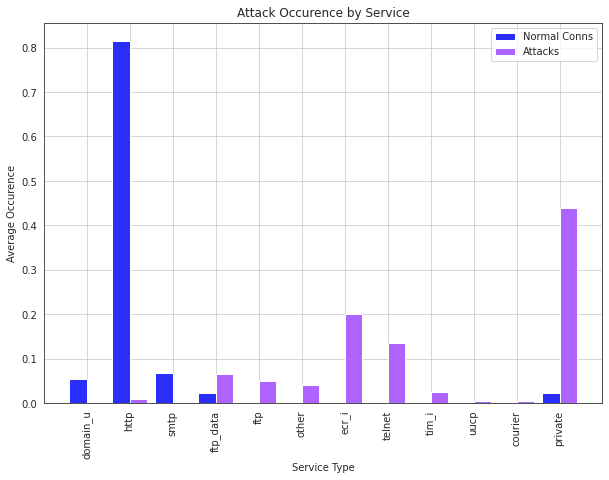

In [15]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

sns.set_style('white')
 
plt.figure(figsize=(10,7))
# set width of bar
barWidth = 0.4
 
# set height of bar
normal = intrusion_means[service_feature_list].iloc[0,:].values
attacks = intrusion_means[service_feature_list].iloc[1,:].values
 
# Set position of bar on X axis
r1 = np.arange(len(normal))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, normal, color='#2a2efa', width=barWidth, edgecolor='white', label='Normal Conns')
plt.bar(r2, attacks, color='#af63ff', width=barWidth, edgecolor='white', label='Attacks')
 
# Add xticks on the middle of the group bars
plt.xticks([r+barWidth/2 for r in range(len(normal))], service_list,rotation=90)
 
# Create legend & Show graphic
plt.legend()
plt.ylabel('Average Occurence')
plt.xlabel('Service Type')
plt.title('Attack Occurence by Service')

plt.grid()
plt.show()

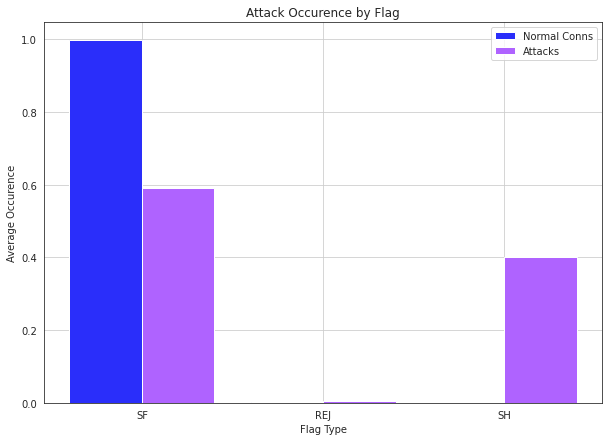

In [16]:
plt.figure(figsize=(10,7))
# set width of bar
barWidth = 0.4
 
# set height of bar
normal = intrusion_means[flag_feature_list].iloc[0,:].values
attacks = intrusion_means[flag_feature_list].iloc[1,:].values
 
# Set position of bar on X axis
r1 = np.arange(len(normal))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, normal, color='#2a2efa', width=barWidth, edgecolor='white', label='Normal Conns')
plt.bar(r2, attacks, color='#af63ff', width=barWidth, edgecolor='white', label='Attacks')
 
# Add xticks on the middle of the group bars
plt.xticks([r+barWidth/2 for r in range(len(normal))], flag_list)
 
# Create legend & Show graphic
plt.legend()
plt.ylabel('Average Occurence')
plt.xlabel('Flag Type')
plt.title('Attack Occurence by Flag')

plt.grid()
plt.show()

In [0]:
important = intrusion_means[other_feature_list].reset_index()

In [0]:
target_map = {0:'Normal Conns', 1:'Attacks'}
important['target'] = important['target'].map(target_map)
column_map = {'num_root':'Root Accesses', 
              'num_shells':'Shell Prompts',	
              'srv_count':'Service Connections',
              'serror_rate':'Rate of SYN Errors',
              'count':'Host Connections'}


In [21]:
important.rename(columns=column_map).round(2)

,target,Root Accesses,Shell Prompts,Service Connections,Rate of SYN Errors,Host Connections
0,Normal Conns,0.04,0.00,18.53,0.0,15.27
1,Attacks,1.61,0.08,3.32,0.4,3.00
